In [1]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader

/mnt/disk1/sumdev/CourseWork/a3_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Dataset and Create Dataloader

In [2]:
# Load training dataset, only the first 50,000 examples
train_dataset = load_dataset("wmt16", "de-en", split="train[:50000]")

# Load validation and test datasets
validation_dataset = load_dataset("wmt16", "de-en", split="validation")
test_dataset = load_dataset("wmt16", "de-en", split="test")

In [3]:
len(train_dataset), len(validation_dataset), len(test_dataset)

(50000, 2169, 2999)

# Setup- 2A

### Model Architecture

In [4]:
import torch
import math
import torch.nn as nn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from typing import Iterable, List

# Define the PositionalEncoding module
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])


class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


# Define the Transformer model
class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, emb_dim=234, nhead=6, num_encoder_layers=5, num_decoder_layers=5, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding_dim = emb_dim
        self.transformer = nn.Transformer(
            d_model=emb_dim, nhead=nhead, num_encoder_layers=num_encoder_layers, 
            num_decoder_layers=num_decoder_layers, dropout=dropout, batch_first=True)
        self.src_token_emb = nn.Embedding(src_vocab_size, emb_dim)
        self.tgt_token_emb = nn.Embedding(tgt_vocab_size, emb_dim)
        self.linear = nn.Linear(emb_dim, tgt_vocab_size)
        self.positional_encoding = PositionalEncoding(emb_dim, dropout=dropout)


    def forward(self, src, tgt, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_padding_mask):
        src_emb = self.positional_encoding(self.src_token_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_token_emb(tgt))
        output = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None, src_padding_mask, tgt_padding_mask, memory_padding_mask)
        output = self.linear(output)
        return output
    
    def encode(self, src, src_mask):
        return self.transformer.encoder(self.positional_encoding(self.src_token_emb(src)), src_mask)

    def decode(self, tgt, memory, tgt_mask):
        return self.transformer.decoder(self.positional_encoding(self.tgt_token_emb(tgt)), memory, tgt_mask)


### Build Vocabulary of the Dataset

In [5]:
from typing import Iterable

# Define function to yield tokens from the dataset
def yield_tokens(data_iter: Iterable, language: str):
    for data_sample in data_iter:
        yield token_transform[language](data_sample['translation'][language])

# Set up tokenizers
token_transform = {}
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')


# Build vocabulary
vocab_transform = {}
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
vocab_transform[SRC_LANGUAGE] = build_vocab_from_iterator(yield_tokens(train_dataset, 'de'), specials=["<unk>", "<pad>", "<bos>", "<eos>"])
vocab_transform[TGT_LANGUAGE] = build_vocab_from_iterator(yield_tokens(train_dataset, 'en'), specials=["<unk>", "<pad>", "<bos>", "<eos>"])
vocab_transform[SRC_LANGUAGE].set_default_index(UNK_IDX)
vocab_transform[TGT_LANGUAGE].set_default_index(UNK_IDX)

In [6]:
vocab_transform[SRC_LANGUAGE]['<unk>'], vocab_transform[TGT_LANGUAGE]['<unk>'], vocab_transform[SRC_LANGUAGE]['<pad>'], vocab_transform[TGT_LANGUAGE]['<pad>'], vocab_transform[SRC_LANGUAGE]['<bos>'], vocab_transform[TGT_LANGUAGE]['<bos>'], vocab_transform[SRC_LANGUAGE]['<eos>'], vocab_transform[TGT_LANGUAGE]['<eos>']

(0, 0, 1, 1, 2, 2, 3, 3)

In [8]:
len(vocab_transform[SRC_LANGUAGE]), len(vocab_transform[TGT_LANGUAGE])

(52604, 23774)

### Create DataSet and DataLoader

In [1]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __getitem__(self, idx):
        german = self.dataset[idx]['translation']['de']
        english = self.dataset[idx]['translation']['en']
        german_token = token_transform[SRC_LANGUAGE](german)
        english_token = token_transform[TGT_LANGUAGE](english)
        german_vocab = torch.tensor([vocab_transform[SRC_LANGUAGE][token] for token in german_token], dtype=torch.long)
        english_vocab = torch.tensor([vocab_transform[TGT_LANGUAGE][token] for token in english_token], dtype=torch.long)
        germen_sentence_length = len(german_vocab)
        english_sentence_length = len(english_vocab)
        return german_vocab, english_vocab, germen_sentence_length, english_sentence_length, idx

    def __len__(self):
        return len(self.dataset)


def collate_fn(batch):
    src_batch, tgt_batch, src_len, tgt_len, idx = zip(*batch)
    src_batch = nn.utils.rnn.pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    tgt_batch = nn.utils.rnn.pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
    src_len = torch.tensor(src_len, dtype=torch.long)
    tgt_len = torch.tensor(tgt_len, dtype=torch.long)
    return src_batch, tgt_batch, src_len, tgt_len, idx


train_data = TextDataset(train_dataset)
val_data = TextDataset(validation_dataset)
test_data = TextDataset(test_dataset)
print(len(train_data), len(val_data), len(test_data))

# Define data loaders
BATCH_SIZE = 64
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
print(len(train_loader), len(val_loader), len(test_loader))

NameError: name 'train_dataset' is not defined

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=device).type(torch.bool)
    src_padding_mask = (src == PAD_IDX)
    tgt_padding_mask = (tgt == PAD_IDX)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [11]:
for src, tgt, src_len, tgt_len, idx in train_loader:
    print(src.shape, tgt.shape, src_len.shape, tgt_len.shape)
    src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt)
    print(src_mask.shape, tgt_mask.shape, src_padding_mask.shape, tgt_padding_mask.shape)
    break

torch.Size([64, 91]) torch.Size([64, 76]) torch.Size([64]) torch.Size([64])
torch.Size([91, 91]) torch.Size([76, 76]) torch.Size([64, 91]) torch.Size([64, 76])


### Training and Evaluation

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_DIM = 256
N_HEAD = 8
NUM_ENCODER_LAYERS = 8
NUM_DECODER_LAYERS = 8
DROPOUT = 0.05
model = TransformerModel(src_vocab_size=SRC_VOCAB_SIZE, tgt_vocab_size=TGT_VOCAB_SIZE, 
            emb_dim=EMB_DIM, nhead=N_HEAD, num_encoder_layers=NUM_ENCODER_LAYERS, 
            num_decoder_layers=NUM_DECODER_LAYERS, dropout=DROPOUT)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-8)

In [41]:
# Training loop
def train(model, iterator, optimizer, criterion):
    model.train()
    model = model.to(device)
    epoch_loss = 0
    for index, (src, tgt, _, _, _) in enumerate(iterator):
        src = src.to(device)
        tgt = tgt.to(device)
        tgt_input = tgt[:, :-1]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        memory_padding_mask = src_padding_mask.clone()
        tgt_out = tgt[:, 1:]
        optimizer.zero_grad()
        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_padding_mask)
        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if index % 100 == 0:
            print(f"Batch {index} Loss: {loss.item()}")
    model = model.to('cpu')
    return epoch_loss / len(iterator)

# Evaluation loop
def evaluate(model, iterator, criterion):
    model.eval()
    model = model.to(device)
    epoch_loss = 0
    with torch.no_grad():
        for src, tgt, _, _, _ in iterator:
            src = src.to(device)
            tgt = tgt.to(device)
            tgt_input = tgt[:, :-1]
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
            memory_padding_mask = src_padding_mask.clone()
            tgt_out = tgt[:, 1:]
            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_padding_mask)
            loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
            epoch_loss += loss.item()
    model = model.to('cpu')
    return epoch_loss / len(iterator)

In [42]:
# Training the model
N_EPOCHS = 10
training_loss = []
validation_loss = []
for epoch in range(N_EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, val_loader, criterion)
    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    print(f'Epoch: {epoch+1} | Train Loss: {train_loss} | Val Loss: {val_loss}')

# Test the model
test_loss = evaluate(model, test_loader, criterion)
print(f'| Test Loss: {test_loss}')

/mnt/disk1/sumdev/CourseWork/a3_env/lib/python3.12/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Batch 0 Loss: 10.220878601074219
Batch 100 Loss: 6.968963146209717
Batch 200 Loss: 6.4077558517456055
Batch 300 Loss: 5.975808143615723
Batch 400 Loss: 5.9370245933532715
Batch 500 Loss: 5.778221130371094
Batch 600 Loss: 5.525778293609619
Batch 700 Loss: 5.508260726928711
Epoch: 1 | Train Loss: 6.22467139370911 | Val Loss: 7.2703906087314385
Batch 0 Loss: 5.538148403167725
Batch 100 Loss: 5.275978088378906
Batch 200 Loss: 5.278611660003662
Batch 300 Loss: 5.162457466125488
Batch 400 Loss: 5.114497184753418
Batch 500 Loss: 5.181527614593506
Batch 600 Loss: 5.241818428039551
Batch 700 Loss: 4.939311504364014
Epoch: 2 | Train Loss: 5.205466532036471 | Val Loss: 7.145123650045956
Batch 0 Loss: 4.958529472351074
Batch 100 Loss: 4.9718828201293945
Batch 200 Loss: 4.929483413696289
Batch 300 Loss: 4.895610809326172
Batch 400 Loss: 4.971885681152344
Batch 500 Loss: 4.903313159942627
Batch 600 Loss: 4.8681206703186035
Batch 700 Loss: 4.6816725730896
Epoch: 3 | Train Loss: 4.8974092903039645 | V

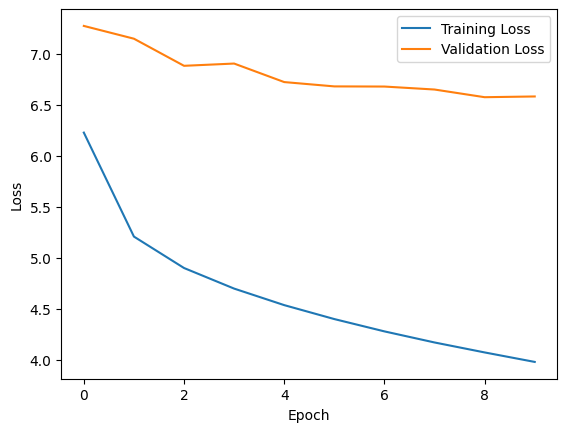

In [43]:
import matplotlib.pyplot as plt

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [44]:
model = model.to('cpu')
torch.save(model.state_dict(), 'q2a_transformer_model.pth')

In [45]:
model_loaded = TransformerModel(src_vocab_size=SRC_VOCAB_SIZE, tgt_vocab_size=TGT_VOCAB_SIZE, 
            emb_dim=EMB_DIM, nhead=N_HEAD, num_encoder_layers=NUM_ENCODER_LAYERS, 
            num_decoder_layers=NUM_DECODER_LAYERS, dropout=DROPOUT)
model_loaded.load_state_dict(torch.load('q2a_transformer_model.pth'))

val_loss = evaluate(model_loaded, val_loader, criterion)
print(f'| Validation Loss: {val_loss}')
test_loss = evaluate(model_loaded, test_loader, criterion)
print(f'| Test Loss: {test_loss}')

| Validation Loss: 6.578901571386001
| Test Loss: 6.708190045458205


### Compute the scores


In [46]:
def translate_sentence(model, sentence, token_transform, vocab_transform, device, max_length):
    model.eval()
    model = model.to(device)
    sentence_token = token_transform[SRC_LANGUAGE](sentence)
    sentence_vocab = torch.tensor([vocab_transform[SRC_LANGUAGE][token] for token in sentence_token], dtype=torch.long)
    sentence_vocab = sentence_vocab.unsqueeze(dim=0)
    sentence_vocab = sentence_vocab.to(device)
    src_mask = torch.zeros((sentence_vocab.shape[1], sentence_vocab.shape[1]),device=device).type(torch.bool)
    memory = model.encode(sentence_vocab, src_mask)
    translation = torch.tensor([vocab_transform[TGT_LANGUAGE]['<bos>']], dtype=torch.long).unsqueeze(0).to(device)
    
    for i in range(max_length):
        tgt_mask = generate_square_subsequent_mask(translation.shape[1]).to(device)
        out = model.decode(translation, memory, tgt_mask)
        
        out = model.linear(out)
        out = out.softmax(dim=-1)
        out = torch.argmax(out, dim=-1)
        translation = torch.cat((translation, out[:, -1].unsqueeze(0)), dim=1)
        if out[:, -1].item() == vocab_transform[TGT_LANGUAGE]['<eos>']:
            break
    translation = translation.squeeze(0)
    translation = translation.cpu().numpy()
    translation = [vocab_transform[TGT_LANGUAGE].lookup_token(token) for token in translation]
    return ' '.join(translation).replace('<bos>', '').replace('<eos>', '')

print(test_dataset[2]['translation']['en'])
print(translate_sentence(model, test_dataset[2]['translation']['de'], token_transform, vocab_transform, device, 20))

The two wanted to talk about the implementation of the international agreement and about Teheran's destabilising activities in the Middle East.
 of the two proposals on the basis of the reform of the two - year programme , the Portuguese Presidency


In [60]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(device)
    src_mask = src_mask.to(device)
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        tgt_mask = (generate_square_subsequent_mask(ys.size(1))
                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.linear(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word[-1].item()
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = token_transform[SRC_LANGUAGE](src_sentence)
    src = torch.tensor([[vocab_transform[SRC_LANGUAGE][token] for token in src]], dtype=torch.long)
    num_tokens = src.shape[1]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

ind = 660
print(test_dataset[ind]['translation']['en'])
print(translate(model, test_dataset[ind]['translation']['de']))

The crash came amid high winds and rain just days before millions arrive in the kingdom for the pilgrimage, which is required at least once in the life of every able-bodied Muslim.
 of the Erika , the United Nations Group has been able to take a report on the basis of a total of the euro , and a number of people who are in favour of the euro , and in


In [61]:
import sacrebleu
from nltk.translate import meteor_score
from torchtext.data.utils import get_tokenizer
from nltk.tokenize import word_tokenize
from bert_score import score
import nltk
nltk.download('wordnet')
nltk.download('punkt')


tokenizer = get_tokenizer("basic_english")

def calculate_bleu(reference_corpus, predicted_corpus):
    return sacrebleu.corpus_bleu(predicted_corpus, [reference_corpus])

def calculate_meteor(reference_corpus, predicted_corpus):
    m_score = 0
    for line in zip(reference_corpus, predicted_corpus):
        ref = word_tokenize(line[0])
        hypo = word_tokenize(line[1])
        # m_score += meteor_score.meteor_score([ref], hypo)
        m_score += meteor_score.single_meteor_score(ref, hypo)
    return m_score / len(reference_corpus)

def calculate_bert_score(reference_corpus, predicted_corpus):
    _, _, bert_scores = score(predicted_corpus, reference_corpus, lang="en", rescale_with_baseline=True)
    return bert_scores.mean().item()

[nltk_data] Downloading package wordnet to
[nltk_data]     /mnt/disk1/sumdev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /mnt/disk1/sumdev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Evaluation Scores on the Validation Set

In [62]:
sentence_german_val, sentence_english_val, sentence_english_translated_val = [], [], []

for i in range(len(validation_dataset)):
    sentence_german_val.append(validation_dataset[i]['translation']['de'])
    sentence_english_val.append(validation_dataset[i]['translation']['en'])
    sentence_english_translated_val.append(translate(model, validation_dataset[i]['translation']['de']))

In [63]:
bleu_score_val = calculate_bleu(sentence_english_translated_val, sentence_english_val)
meteor_score_val = calculate_meteor(sentence_english_translated_val, sentence_english_val)
bert_score_val = calculate_bert_score(sentence_english_translated_val, sentence_english_val)

print(f'BLEU Score: {bleu_score_val.score}')
print(f'BLEU-1 Score: {bleu_score_val.precisions[0]}')
print(f'BLEU-2 Score: {bleu_score_val.precisions[1]}')
print(f'BLEU-3 Score: {bleu_score_val.precisions[2]}')
print(f'BLEU-4 Score: {bleu_score_val.precisions[3]}')
print(f'METEOR Score: {meteor_score_val}')
print(f'BERT Score: {bert_score_val}')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BLEU Score: 0.9478835493638972
BLEU-1 Score: 23.710785263656526
BLEU-2 Score: 3.0627456294890907
BLEU-3 Score: 0.3182368727289999
BLEU-4 Score: 0.060082613593691325
METEOR Score: 0.12734655510735712
BERT Score: -0.04137616232037544


In [67]:
for i in range(5):
    print('==> Sentence', i+1)
    print(f'German: {sentence_german_val[i]}')
    print(f'English: {sentence_english_val[i]}')
    print(f'Translated: {sentence_english_translated_val[i]}')

==> Sentence 1
German: Die Premierminister Indiens und Japans trafen sich in Tokio.
English: India and Japan prime ministers meet in Tokyo
Translated:  and foremost , the situation in Europe is being made . It is also
==> Sentence 2
German: Indiens neuer Premierminister Narendra Modi trifft bei seinem ersten wichtigen Auslandsbesuch seit seinem Wahlsieg im Mai seinen japanischen Amtskollegen Shinzo Abe in Toko, um wirtschaftliche und sicherheitspolitische Beziehungen zu besprechen.
English: India's new prime minister, Narendra Modi, is meeting his Japanese counterpart, Shinzo Abe, in Tokyo to discuss economic and security ties, on his first major foreign visit since winning May's election.
Translated:  - year , the Portuguese Presidency has had a great deal of progress in the past , and in particular , to the end of the United Kingdom , in the last few weeks , in
==> Sentence 3
German: Herr Modi befindet sich auf einer fünftägigen Reise nach Japan, um die wirtschaftlichen Beziehungen m

### Evaluation Scores on the Test Set

In [65]:
sentence_german_test, sentence_english_test, sentence_english_translated_test = [], [], []

for i in range(len(test_dataset)):
    sentence_german_test.append(test_dataset[i]['translation']['de'])
    sentence_english_test.append(test_dataset[i]['translation']['en'])
    sentence_english_translated_test.append(translate(model, test_dataset[i]['translation']['de']))

bleu_score_test = calculate_bleu(sentence_english_translated_test, sentence_english_test)
meteor_score_test = calculate_meteor(sentence_english_translated_test, sentence_english_test)
bert_score_test = calculate_bert_score(sentence_english_translated_test, sentence_english_test)

print(f'BLEU Score: {bleu_score_test.score}')
print(f'BLEU-1 Score: {bleu_score_test.precisions[0]}')
print(f'BLEU-2 Score: {bleu_score_test.precisions[1]}')
print(f'BLEU-3 Score: {bleu_score_test.precisions[2]}')
print(f'BLEU-4 Score: {bleu_score_test.precisions[3]}')
print(f'METEOR Score: {meteor_score_test}')
print(f'BERT Score: {bert_score_test}')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BLEU Score: 1.004693931335485
BLEU-1 Score: 23.599868993590043
BLEU-2 Score: 2.9466623036649215
BLEU-3 Score: 0.3475507991947833
BLEU-4 Score: 0.0798214901220906
METEOR Score: 0.12672719694687268
BERT Score: -0.054380256682634354


In [66]:
for i in range(5):
    print('==> Sentence', i+1)
    print(f'German: {sentence_german_test[i]}')
    print(f'English: {sentence_english_test[i]}')
    print(f'Translated: {sentence_english_translated_test[i]}')

==> Sentence 1
German: Obama empfängt Netanyahu
English: Obama receives Netanyahu
Translated:  of the cost of the cost of
==> Sentence 2
German: Das Verhältnis zwischen Obama und Netanyahu ist nicht gerade freundschaftlich.
English: The relationship between Obama and Netanyahu is not exactly friendly.
Translated:  and a number of things are not being made by a majority of the United
==> Sentence 3
German: Die beiden wollten über die Umsetzung der internationalen Vereinbarung sowie über Teherans destabilisierende Maßnahmen im Nahen Osten sprechen.
English: The two wanted to talk about the implementation of the international agreement and about Teheran's destabilising activities in the Middle East.
Translated:  of the two proposals on the basis of the reform of the two - year programme , the Portuguese Presidency and the Portuguese
==> Sentence 4
German: Bei der Begegnung soll es aber auch um den Konflikt mit den Palästinensern und die diskutierte Zwei-Staaten-Lösung gehen.
English: The 